This is an implementation of ResNet Image Classifier based on the paper: 
https://arxiv.org/pdf/1512.03385.pdf

This model uses residual skip connections that allows a network to go deeper without suffering from the vanishing/ explodiing gradient problem


# Initializations and Imports

In [3]:
# Importing Tensorflow
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, AveragePooling2D, Concatenate, Add, Activation, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

import numpy as np

# import random, os for data loading 
import random, os

import matplotlib.pyplot as plt

# pandas for displaying confusion matrix 
import pandas as pd

print(tf.__version__)

# Display GPU availability if any
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print("devices =" , tf.config.list_physical_devices())

print(get_available_gpus()) 

2.5.0
devices = [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['/device:GPU:0']


In [4]:
# Set the seed value for consistent results

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

## Parameter Initializations

In [28]:
# Input image dimensions
input_shape = (224, 224, 3)

# number of images to process in a batch
batch_size = 30

# Number of categories in the dataset
num_classes = 5

checkpoint_filePath = '/content/drive/MyDrive/MachineLearning/ResNet_2.h5'


# Data Loading and Preprocessing

## Procuring the Dataset

In [6]:
path='/content/Linnaeus 5 256X256'
# Check if the folder with the dataset already exists, if not copy it from the saved location
if not os.path.isdir(path):
  !cp '/content/drive/MyDrive/MachineLearning/Linnaeus 5 256X256.rar' '/content/' 
  get_ipython().system_raw("unrar x '/content/Linnaeus 5 256X256.rar'")



categories = os.listdir(os.path.join(path, 'train'))
print(len(categories), " categories found =", categories)

5  categories found = ['dog', 'bird', 'flower', 'other', 'berry']


## Training and Validation Dataset

In [7]:

train_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'train')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , shuffle=True
      , seed=2
      , validation_split=0.1
      , subset= 'training'
  )

validation_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'train')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , shuffle=True
      , seed=2
      , validation_split=0.1
      , subset= 'validation'
  )


print("Training class names found =" , train_image_dataset.class_names)

def crop_images(images, labels):
  '''
  Expecting categories to be names of subfolders and the images belonging to each 
  of the subfolders be stored inside them. While reading the images, they are resized to 256x256x3
  and then cropped to 224x224x3 based on the way the paper describes (randomly between 4 corners and center)
  diagnostics: bool (default False), If True it will print a lot of debug information

  '''
  # In order to clip the image in either from top-left, top-right, bottom-left, bottom-right or center, 
  # we create an array of possible start positions
  corners_list = [0, (256-input_shape[0])//2, 256-input_shape[0]]
  
  # Sampling one number from the list of start positions
  offset_height = offset_width = random.sample(corners_list, 1)[0]
  
  images = tf.image.per_image_standardization(images-127)
  images = images/tf.math.reduce_max(tf.math.abs(images))

  # Since there is an auxillary arm of the model, we have to concatenate two labels with each other during training
  return  tf.image.crop_to_bounding_box(images, offset_height, offset_width, input_shape[0], input_shape[0]), labels #(labels, labels)


validation_datasource = validation_image_dataset.map(crop_images)
validation_datasource = validation_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)

training_datasource = train_image_dataset.map(crop_images)
training_datasource = training_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)



Found 6000 files belonging to 5 classes.
Using 5400 files for training.
Found 6000 files belonging to 5 classes.
Using 600 files for validation.
Training class names found = ['dog', 'bird', 'flower', 'other', 'berry']


In [8]:
for images, labels in training_datasource:
  print("images =", images.shape)
  print("labels =", type(labels))
  break

training_datasource = train_image_dataset.map(crop_images)
training_datasource = training_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)


images = (30, 224, 224, 3)
labels = <class 'tensorflow.python.framework.ops.EagerTensor'>


## Test Data

In [9]:
test_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'test')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , seed=2
  )
def test_data_crop_images(images, labels):
  '''
  Definiing separate function for test data because labels do not have to be 
   concatenated during testing and the map function does not allow multiple function calls

  Expecting categories to be names of subfolders and the images belonging to each 
  of the subfolders be stored inside them. While reading the images, they are resized to 256x256x3
  and then cropped to 224x224x3 based on the way the paper describes (randomly between 4 corners and center)
  diagnostics: bool (default False), If True it will print a lot of debug information

  '''
  # In order to clip the image in either from top-left, top-right, bottom-left, bottom-right or center, 
  # we create an array of possible start positions
  corners_list = [0, (256-input_shape[0])//2, 256-input_shape[0]]
  
  # Sampling one number from the list of start positions
  offset_height = offset_width = random.sample(corners_list, 1)[0]
  
  images = tf.image.per_image_standardization(images-127)
  images = images/tf.math.reduce_max(tf.math.abs(images))
  # Since there is an auxillary arm of the model, we have to concatenate two labels with each other during training
  return  tf.image.crop_to_bounding_box(images, offset_height, offset_width, input_shape[0], input_shape[0]), labels


test_datasource = test_image_dataset.map(test_data_crop_images)
test_datasource = test_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)

Found 2000 files belonging to 5 classes.


# Model Architecture

## Define the Residual Block

In [10]:
def residual_block(input, filter_configs, shortcut_filter_configs, name_prefix=''):
  '''
  This function is to define the residual block that is specified in the paper. 
  Based on the shortcut_filteere_configs parameters, the function can either 
  directly join the input with the output of the conv filters on the main path, 
  or,
  can add conv filters in the shortcut and then add to the main path.

  After addition of the shortcut and the main path, the output is provided
   through an activation layer

  Parameters:
  input: input Tensor
  filter_configs: list of dictionary with convolution filter configurations in the main path. 
        Each item in the list is a layer inside the residual block. The 
        dictionary should be of the form -
               {'filters': number of filters for the 
               , 'kernel_size':  kernel size of the filter
               , 'strides': strides of the filter
               , 'padding': padding of the filter
               , 'activation': Activatioin of the convolution filter
               }
  shortcut_filter_configs: list of dictionaries with convolution filter 
        configurations for the filters in the shortcut path. 
        Structure of the dictionary is the same as filter_configs
  name_prefix = String that will be added as a prefix to all layers of the block
  '''
  shortcut_path = input # This is for the shortcut path
  
  main_path = input # This is for the main path
  for i, config in enumerate(filter_configs): 
    # Going through the main path conv filter creations
    main_path = Conv2D(filters = config['filters']
               , kernel_size = config['kernel_size']
               , strides=config['strides']
               , padding=config['padding']
               , activation=config['activation']
               , use_bias=True
               , kernel_initializer='glorot_uniform'
               , name=name_prefix + '_main_'+ str(i+1)
          )(main_path)
  
  # Check if the shortcut filter configs has been defined
  if shortcut_filter_configs is not None: 
    # We need to add filters in the shortcut path
    # As per the paper, there only needs to be 1x1 kernel filter with the required depth, 
    # but the code here gives the "unwanted/ unwarranted" freedom to define multiple

    for i, config in enumerate(shortcut_filter_configs):
      # Go through the list of filters and create the conv filters
      shortcut_path = Conv2D(filters = config['filters']
               , kernel_size = config['kernel_size']
               , strides=config['strides']
               , padding=config['padding']
               , activation=config['activation']
               , use_bias=True
               , kernel_initializer='glorot_uniform'
               , name = name_prefix + '_shortcut_' + str(i+1)
          )(shortcut_path)
  # Going through the Add layer to add the input with the output of 
  combined_path = Add(name=name_prefix + '_add_junction')([shortcut_path, main_path])

  # The output of the Add has to go through an activation layer
  residual_block_output = Activation('elu', name=name_prefix + '_activation_output')(combined_path)
  # TODO: Make the activation method here as a configurable parameter
  
  return residual_block_output


## Define the architecture of the model

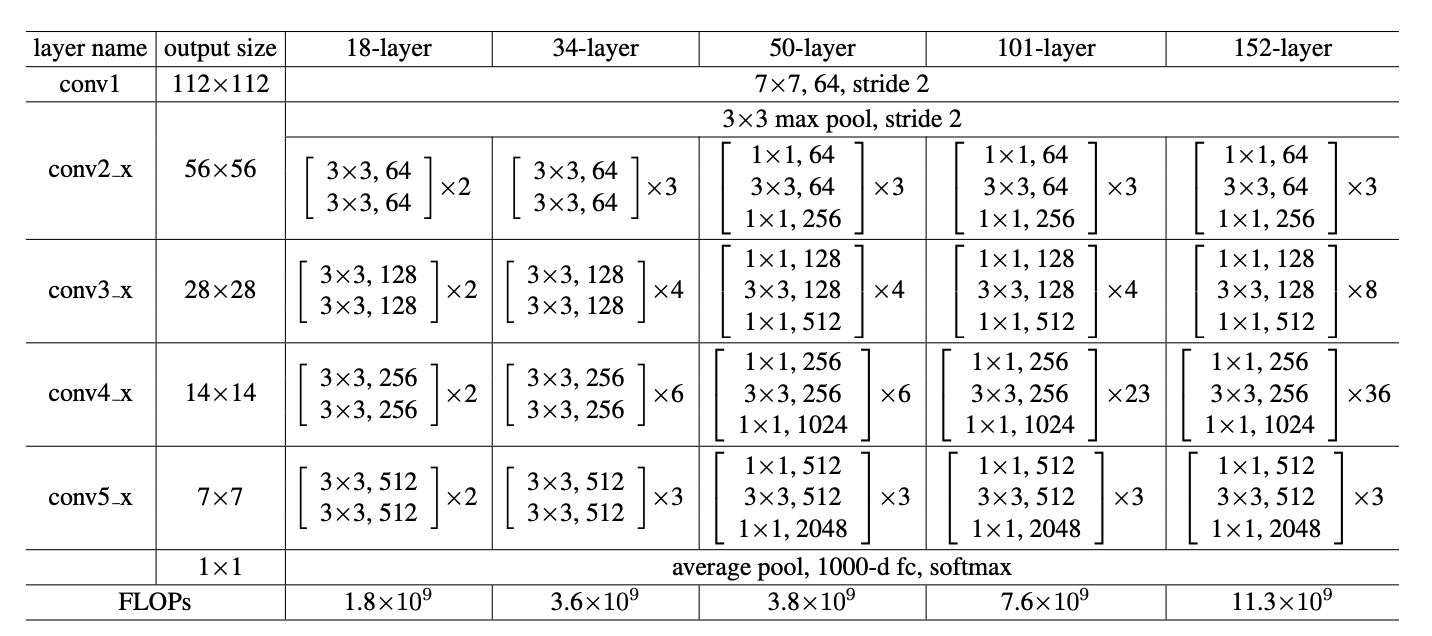

## ResNet50 residual block configurations

In [11]:
def get_resnet50_config():
  # First 3 residual blocks have in their main path, 1x1x64, 3x3x64, 1x1x256
  # Since the output of the maxpool_1 is of depth 64, only the first residual 
  # block will require a 1x1x256 filter in its shortcut path 

  conv2_1_2_3_filter_configs= [
        {'filters': 64, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 64, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 256, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': None}
      ]
  conv2_1_shortcut_filter_configs = [
    {'filters': 256, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': 'elu'}                                   
  ]

  # Next 4 residual blocks in Conv3_x have filters 1x1x128, 3x3x128, 1x1x512
  # The output of the previous block has depth of 256, so the first of the 4 residual blocks 
  # will require a 1x1x512 conv filter in its shortcut path, the others will have identity functions

  # Conv3_1 will have stride = 2, so that will be defined separately
  # stride 2 will reduce the width and height from 56x56 to 28x28
  conv3_1_filter_configs= [
        {'filters': 128, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 128, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 512, 'kernel_size': 1, 'strides': 2, 'padding': 'same', 'activation': None}
      ]

  conv3_1_shortcut_filter_configs = [
    {'filters': 512, 'kernel_size': 1, 'strides': 2, 'padding': 'same', 'activation': 'elu'}                                   
  ]

  # Rest of the 3 blocks of conv3 are defined below
  conv3_2_3_4_filter_configs= [
        {'filters': 128, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 128, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 512, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': None}
      ]

  # There will be 6 blocks in conv4_x
  # conv4_1 will have strride = 2
  # widthxheight will be reduced from 28x28 to 14x14
  conv4_1_filter_configs= [
        {'filters': 256, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 256, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 1024, 'kernel_size': 1, 'strides': 2, 'padding': 'same', 'activation': None}
      ]
  conv4_1_shortcut_filter_configs = [
    {'filters': 1024, 'kernel_size': 1, 'strides': 2, 'padding': 'same', 'activation': 'elu'}                                   
  ]
  # Rest of the conv4_x blocks:
  conv4_2_to_6_filter_configs= [
        {'filters': 256, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 256, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 1024, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': None}
      ]

  # conv5_x has 3 blocks
  # conv5_1 will have stride =2 
  # widthxheight will reduce from 14x14 to 7x7
  conv5_1_filter_configs= [
        {'filters': 512, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 512, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 2048, 'kernel_size': 1, 'strides': 2, 'padding': 'same', 'activation': None}
      ]
  conv5_1_shortcut_filter_configs = [
    {'filters': 2048, 'kernel_size': 1, 'strides': 2, 'padding': 'same', 'activation': 'elu'}                                   
  ]

  conv5_2_3_filter_configs= [
        {'filters': 512, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 512, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 2048, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': None}
      ]

  resNet50_residual_block_config = [
      (conv2_1_2_3_filter_configs, conv2_1_shortcut_filter_configs, "conv2_1"), # Conv 2_1
      (conv2_1_2_3_filter_configs, None, "conv2_2"),                            # Conv 2_2
      (conv2_1_2_3_filter_configs, None, "conv2_3"),                            # Conv 2_3
      (conv3_1_filter_configs, conv3_1_shortcut_filter_configs, "conv3_1"),     # Conv 3_1
      (conv3_2_3_4_filter_configs, None, "conv3_2"),                            # Conv 3_2
      (conv3_2_3_4_filter_configs, None, "conv3_3"),                            # Conv 3_3
      (conv3_2_3_4_filter_configs, None, "conv3_4"),                            # Conv 3_4
      (conv4_1_filter_configs, conv4_1_shortcut_filter_configs, "conv4_1"),     # Conv 4_1
      (conv4_2_to_6_filter_configs, None, "conv4_2"),                           # Conv 4_2
      (conv4_2_to_6_filter_configs, None, "conv4_3"),                           # conv 4_3
      (conv4_2_to_6_filter_configs, None, "conv4_4"),                           # conv 4_4
      (conv4_2_to_6_filter_configs, None, "conv4_5"),                           # conv 4_5
      (conv4_2_to_6_filter_configs, None, "conv4_6"),                           # conv 4_6
      (conv5_1_filter_configs, conv5_1_shortcut_filter_configs, "conv5_1"),     # conv 5_1
      (conv5_2_3_filter_configs, None, "conv5_2"),                              # conv 5_2
      (conv5_2_3_filter_configs, None, "conv5_3")                               # conv 5_3
  ]
  return resNet50_residual_block_config


## ResNet34 model configuration

In [12]:
def get_resnet34_config():
  # First 2 residual blocks have in their main path, 3x3x64
  # Since the output of the maxpool_1 is of depth 64, shortcut paths can just be identity 

  conv2_1_2_3_filter_configs= [
        {'filters': 64, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 64, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': None}
      ]

  # Next 4 residual blocks in Conv3_x have filters 3x3x128, 3x3x128
  # The output of the previous block has depth of 64, so the first of the 4 residual blocks 
  # will require a 1x1x128 conv filter in its shortcut path, the others will have identity functions

  # Conv3_1 will have stride = 2, so that will be defined separately
  # stride 2 will reduce the width and height from 56x56 to 28x28
  conv3_1_filter_configs= [
        {'filters': 128, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 128, 'kernel_size': 3, 'strides': 2, 'padding': 'same', 'activation': None}
      ]

  conv3_1_shortcut_filter_configs = [
    {'filters': 128, 'kernel_size': 1, 'strides': 2, 'padding': 'same', 'activation': 'elu'}                                   
  ]

  # Rest of the 3 blocks of conv3 are defined below with stride 1
  conv3_2_3_4_filter_configs= [
        {'filters': 128, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 128, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': None}
      ]

  # There will be 6 blocks in conv4_x
  # conv4_1 will have strride = 2
  # widthxheight will be reduced from 28x28 to 14x14
  conv4_1_filter_configs= [
        {'filters': 256, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 256, 'kernel_size': 3, 'strides': 2, 'padding': 'same', 'activation': None}
      ]
  conv4_1_shortcut_filter_configs = [
    {'filters': 256, 'kernel_size': 1, 'strides': 2, 'padding': 'same', 'activation': 'elu'}                                   
  ]
  # Rest of the conv4_x blocks:
  conv4_2_to_6_filter_configs= [
        {'filters': 256, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 256, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': None}
      ]

  # conv5_x has 3 blocks
  # conv5_1 will have stride =2 
  # widthxheight will reduce from 14x14 to 7x7
  conv5_1_filter_configs= [
        {'filters': 512, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 512, 'kernel_size': 3, 'strides': 2, 'padding': 'same', 'activation': None}
      ]
  conv5_1_shortcut_filter_configs = [
    {'filters': 512, 'kernel_size': 1, 'strides': 2, 'padding': 'same', 'activation': 'elu'}                                   
  ]

  # block 2 and 3 will have stride = 1
  conv5_2_3_filter_configs= [
        {'filters': 512, 'kernel_size': 1, 'strides': 1, 'padding': 'same', 'activation': 'elu'},
        {'filters': 512, 'kernel_size': 3, 'strides': 1, 'padding': 'same', 'activation': None}
      ]

  resNet34_residual_block_config = [
      (conv2_1_2_3_filter_configs, None, "conv2_1"), # Conv 2_1
      (conv2_1_2_3_filter_configs, None, "conv2_2"),                            # Conv 2_2
      (conv2_1_2_3_filter_configs, None, "conv2_3"),                            # Conv 2_3
      (conv3_1_filter_configs, conv3_1_shortcut_filter_configs, "conv3_1"),     # Conv 3_1
      (conv3_2_3_4_filter_configs, None, "conv3_2"),                            # Conv 3_2
      (conv3_2_3_4_filter_configs, None, "conv3_3"),                            # Conv 3_3
      (conv3_2_3_4_filter_configs, None, "conv3_4"),                            # Conv 3_4
      (conv4_1_filter_configs, conv4_1_shortcut_filter_configs, "conv4_1"),     # Conv 4_1
      (conv4_2_to_6_filter_configs, None, "conv4_2"),                           # Conv 4_2
      (conv4_2_to_6_filter_configs, None, "conv4_3"),                           # conv 4_3
      (conv4_2_to_6_filter_configs, None, "conv4_4"),                           # conv 4_4
      (conv4_2_to_6_filter_configs, None, "conv4_5"),                           # conv 4_5
      (conv4_2_to_6_filter_configs, None, "conv4_6"),                           # conv 4_6
      (conv5_1_filter_configs, conv5_1_shortcut_filter_configs, "conv5_1"),     # conv 5_1
      (conv5_2_3_filter_configs, None, "conv5_2"),                              # conv 5_2
      (conv5_2_3_filter_configs, None, "conv5_3")                               # conv 5_3
  ]
  return resNet34_residual_block_config


## Building the model

In [13]:
def build_model(residual_block_config):
  # input layer definition, input shape = 224x224x3
  input = Input (shape=input_shape, batch_size = batch_size, name='main_input')

  #First layer is a conv filter as per the paper, output = 112x112x64
  main_path = Conv2D(filters=64, kernel_size= 7, strides= 2, padding='same'
                  , activation='elu', use_bias = True, name='conv1')(input)

  # MaxPool layer output = 56x56x64 
  main_path = MaxPool2D(pool_size=3, strides=2, padding='same'
                        , name='maxpool_1')(main_path)


  # Create the chain of residual blocks using the below for loop
  for filter_configs, shortcut_filter_configs, name_prefix in residual_block_config:
    main_path = residual_block(main_path
                              , filter_configs
                              , shortcut_filter_configs
                              , name_prefix= name_prefix
                              )

  #AveragePool layer and getting ready to create the output classification layer, 
  main_path = AveragePooling2D(pool_size = 7, strides = 7, padding='same'
                              , name='avg_pool')(main_path)

  # Flatten the data to get it ready for FC layer
  main_path = Flatten(name="flatten")(main_path)

  #Adding final FC layer to classify the output
  main_path = Dense(num_classes, activation='softmax', name='fc_final_output')(main_path)

  model= Model(inputs=input, outputs = main_path)
  return model


## Create ResNet50 Model

In [14]:
resNet50_residual_block_config = get_resnet50_config()
model = build_model(resNet50_residual_block_config)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(30, 224, 224, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (30, 112, 112, 64)   9472        main_input[0][0]                 
__________________________________________________________________________________________________
maxpool_1 (MaxPooling2D)        (30, 56, 56, 64)     0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2_1_main_1 (Conv2D)         (30, 56, 56, 64)     4160        maxpool_1[0][0]                  
______________________________________________________________________________________________

### Resnet50 Model figure

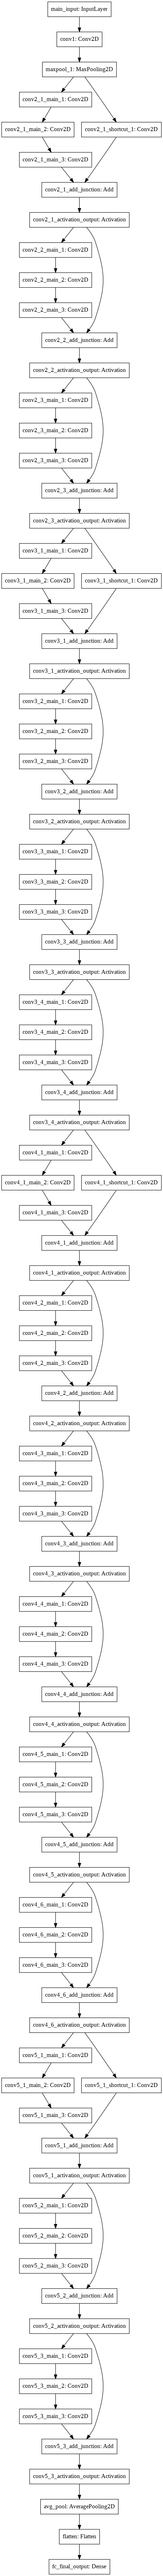

In [15]:
tf.keras.utils.plot_model(model)

## Create ResNet34 Model

In [16]:
resNet34_residual_block_config = get_resnet34_config()
model = build_model(resNet34_residual_block_config)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(30, 224, 224, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (30, 112, 112, 64)   9472        main_input[0][0]                 
__________________________________________________________________________________________________
maxpool_1 (MaxPooling2D)        (30, 56, 56, 64)     0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2_1_main_1 (Conv2D)         (30, 56, 56, 64)     36928       maxpool_1[0][0]                  
____________________________________________________________________________________________

### ResNet34 Model Figure

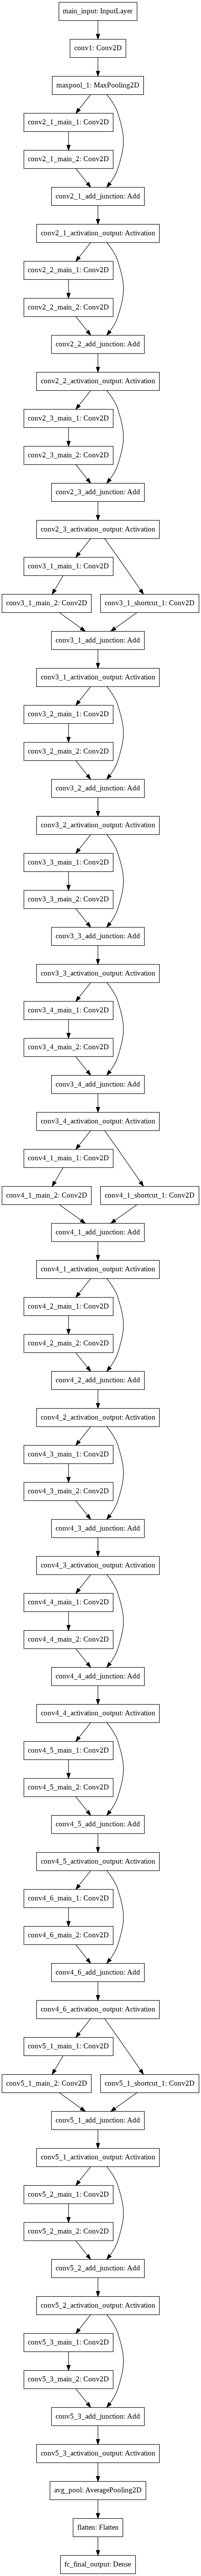

In [17]:
tf.keras.utils.plot_model(model)

# Training Prep

## Callbacks Declaration

### Learning Rate Scheduler

In [29]:
def lr_control(epoch, learning_rate):
  #The paper talks about reducing the learning rate by 4% every 8 epochs
  tf.print("inside lr_control, epoch =", epoch, " lr = ", learning_rate)
  #Checking if 8 epochs are complete
  if epoch > 7 and epoch%8 == 0 :
    # Reducing the learning rate by 10% 
    return learning_rate* 0.9
  else:
    return learning_rate

lrScheduler = tf.keras.callbacks.LearningRateScheduler(schedule=lr_control, verbose=1)

### Model Checkpoint

In [30]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filePath
                                                , monitor='val_loss'
                                                , verbose = 1
                                                , save_best_only = True
                                                , save_weights_only = False
                                                )


### Early Stopper

In [31]:
earlyStopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss'
                                                , min_delta = 0.0001
                                                , patience = 9
                                                , verbose=1
                                                , restore_best_weights=True
                                                )

## Model Compilation

In [21]:

optimizer = SGD(learning_rate=0.00001, momentum=0.9)

model.compile(optimizer=optimizer
              , loss = 'categorical_crossentropy'
              , metrics = [ 'accuracy']
              )



# Train Model

Training ResNet34 to avoid heavy computation on Colab

In [22]:
# Start the training process and collect the metrics data for plotting
metrics = model.fit(training_datasource
          , epochs=50
          , batch_size=batch_size
          , validation_data = validation_datasource
          , callbacks = [lrScheduler, checkpoint, earlyStopper]
          )

Epoch 1/50
inside lr_control, epoch = 0  lr =  9.999999747378752e-06

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
180/180 [==============================] - 70s 194ms/step - loss: 1.5451 - accuracy: 0.3072 - val_loss: 1.5019 - val_accuracy: 0.3417

Epoch 00001: val_loss improved from inf to 1.50194, saving model to /content/drive/MyDrive/MachineLearning/ResNet.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
inside lr_control, epoch = 1  lr =  9.999999747378752e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
180/180 [==============================] - 35s 194ms/step - loss: 1.4661 - accuracy: 0.3524 - val_loss: 1.4729 - val_accuracy: 0.3433

Epoch 00002: val_loss improved from 1.50194 to 1.47287, saving model to /content/drive/MyDrive/MachineLearning/ResNet.h5
Epoch 3/50
inside lr_control, epoch = 2  lr =  9.999999747378752e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
180/180 [==============================] - 36s 200ms/step - loss: 1.4366 - accuracy: 0.3804 - val_loss: 1.4467 - val_accuracy: 0.3517

Epoch 00003: val_loss improved from 1.47287 to 1.44669, saving model to /content/drive/MyDrive/MachineLearning/ResNet.h5
Epoch 4/50
inside lr_control, epoch = 3  lr =  9.999999747378752e-06

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
180/180 [=================

## Plot Loss and Accuracy

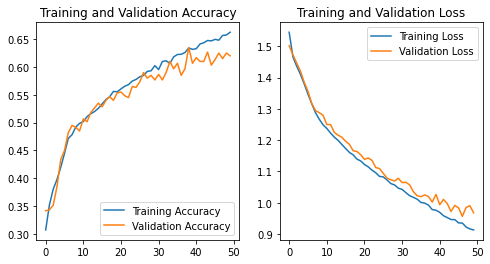

In [27]:
import matplotlib.pyplot as plt
acc = metrics.history['accuracy']
val_acc = metrics.history['val_accuracy']

loss = metrics.history['loss']
val_loss = metrics.history['val_loss']

epochs_range = range(len(metrics.history['accuracy']))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test the Model

In [24]:
predictions = []
actuals=[]

for i, (images, labels) in enumerate( test_datasource):
  pred = model(images)
  for j in range(len(labels)):
    actuals.append( labels[j])
    predictions.append(pred[j])

# Printing a few labels and predictions to ensure that there are no dead-Relus
for j in range(10):
  print(labels[j].numpy(), "\t", pred[j].numpy())

[0. 1. 0. 0. 0.] 	 [0.0235266  0.10897809 0.3271751  0.03340529 0.5069149 ]
[0. 1. 0. 0. 0.] 	 [0.06303899 0.3555932  0.147747   0.41043457 0.02318621]
[0. 1. 0. 0. 0.] 	 [0.12345209 0.6606989  0.02768849 0.11548411 0.07267643]
[0. 1. 0. 0. 0.] 	 [0.25657988 0.2589431  0.09734413 0.36727422 0.0198587 ]
[0. 0. 0. 1. 0.] 	 [0.08905374 0.2783467  0.0774235  0.5402862  0.0148899 ]
[0. 0. 1. 0. 0.] 	 [1.1086810e-06 2.3582480e-03 9.1496962e-01 7.3341923e-03 7.5336881e-02]
[0. 0. 0. 0. 1.] 	 [0.02767825 0.00861757 0.06848286 0.001408   0.8938133 ]
[0. 0. 1. 0. 0.] 	 [5.0281787e-06 5.5233145e-04 9.9243379e-01 2.6762958e-03 4.3324889e-03]
[0. 0. 0. 1. 0.] 	 [0.2789667  0.16835254 0.0278518  0.5011415  0.0236875 ]
[0. 0. 0. 0. 1.] 	 [0.01274782 0.03140369 0.17357181 0.00523592 0.7770408 ]


## Confusion Matrix

In [25]:
pd.DataFrame(tf.math.confusion_matrix(
    np.argmax(actuals, axis=1), np.argmax(predictions, axis=1), num_classes=num_classes, dtype=tf.dtypes.int32).numpy()
    , columns = test_image_dataset.class_names
    , index =  test_image_dataset.class_names)

,dog,bird,flower,other,berry
dog,278,44,16,44,18
bird,76,166,37,59,62
flower,12,21,283,13,71
other,45,54,37,237,27
berry,21,28,43,16,292


# Training for 50 more epochs

In [32]:
# Start the training process and collect the metrics data for plotting
metrics = model.fit(training_datasource
          , epochs=50
          , batch_size=batch_size
          , validation_data = validation_datasource
          , callbacks = [lrScheduler, checkpoint, earlyStopper]
          )

Epoch 1/50
inside lr_control, epoch = 0  lr =  5.314409918355523e-06

Epoch 00001: LearningRateScheduler reducing learning rate to 5.314409918355523e-06.
180/180 [==============================] - 37s 204ms/step - loss: 0.9105 - accuracy: 0.6563 - val_loss: 0.9818 - val_accuracy: 0.6100

Epoch 00001: val_loss improved from inf to 0.98180, saving model to /content/drive/MyDrive/MachineLearning/ResNet_2.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
inside lr_control, epoch = 1  lr =  5.314409918355523e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 5.314409918355523e-06.
180/180 [==============================] - 35s 195ms/step - loss: 0.9078 - accuracy: 0.6594 - val_loss: 1.0096 - val_accuracy: 0.6033

Epoch 00002: val_loss did not improve from 0.98180
Epoch 3/50
inside lr_control, epoch = 2  lr =  5.314409918355523e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 5.314409918355523e-06.
180/180 [==============================] - 35s 197ms/step - loss: 0.8972 - accuracy: 0.6617 - val_loss: 0.9518 - val_accuracy: 0.6433

Epoch 00003: val_loss improved from 0.98180 to 0.95182, saving model to /content/drive/MyDrive/MachineLearning/ResNet_2.h5
Epoch 4/50
inside lr_control, epoch = 3  lr =  5.314409918355523e-06

Epoch 00004: LearningRateScheduler reducing learning rate to 5.314409918355523e-06.
180/180 [==============================] - 36s 197ms/step - loss: 0.8965 - accuracy: 0.6676 - 

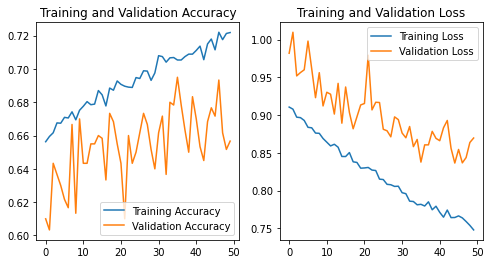

In [35]:
import matplotlib.pyplot as plt
acc = metrics.history['accuracy']
val_acc = metrics.history['val_accuracy']

loss = metrics.history['loss']
val_loss = metrics.history['val_loss']

epochs_range = range(len(metrics.history['accuracy']))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Regenerating the Confusion Matrix

In [33]:
predictions = []
actuals=[]

for i, (images, labels) in enumerate( test_datasource):
  pred = model(images)
  for j in range(len(labels)):
    actuals.append( labels[j])
    predictions.append(pred[j])

# Printing a few labels and predictions to ensure that there are no dead-Relus
for j in range(10):
  print(labels[j].numpy(), "\t", pred[j].numpy())

[0. 1. 0. 0. 0.] 	 [0.01077838 0.34070885 0.3440716  0.05659881 0.24784239]
[1. 0. 0. 0. 0.] 	 [9.2472053e-01 2.7816322e-02 4.1169493e-04 4.6582796e-02 4.6863515e-04]
[0. 1. 0. 0. 0.] 	 [0.5207156  0.25393432 0.06951063 0.10588971 0.04994976]
[1. 0. 0. 0. 0.] 	 [0.8596171  0.05024306 0.00718466 0.08116411 0.00179107]
[0. 0. 1. 0. 0.] 	 [8.9897007e-10 1.3873712e-05 9.9563569e-01 4.1923081e-03 1.5811349e-04]
[0. 0. 0. 0. 1.] 	 [0.01755744 0.1187838  0.21793851 0.05667475 0.58904546]
[1. 0. 0. 0. 0.] 	 [0.4189833  0.4218033  0.04952971 0.03220975 0.07747391]
[0. 0. 0. 1. 0.] 	 [5.75252634e-05 1.39359403e-02 6.97477162e-01 2.78257489e-01
 1.02719115e-02]
[0. 0. 0. 1. 0.] 	 [0.03660994 0.15446916 0.09701248 0.30783463 0.4040738 ]
[0. 1. 0. 0. 0.] 	 [0.39282748 0.5328101  0.0057617  0.00335127 0.06524937]


In [34]:
pd.DataFrame(tf.math.confusion_matrix(
                  np.argmax(actuals, axis=1)
                  , np.argmax(predictions, axis=1)
                  , num_classes=num_classes
                  , dtype=tf.dtypes.int32).numpy()
    , columns = test_image_dataset.class_names
    , index =  test_image_dataset.class_names)

,dog,bird,flower,other,berry
dog,281,44,4,67,4
bird,46,234,21,75,24
flower,4,38,266,43,49
other,20,57,22,285,16
berry,12,54,39,19,276
